# Economic Connectedness

This is the first assignment of the Applied Machine Learning course. In this assignment we will replicate partly two studies carried out on social capital. The studies appeared in the journal Nature:

- Chetty, R., Jackson, M.O., Kuchler, T. et al. Social capital I: measurement and associations with economic mobility. Nature 608, 108–121 (2022). https://doi.org/10.1038/s41586-022-04996-4.


- Chetty, R., Jackson, M.O., Kuchler, T. et al. Social capital II: determinants of economic connectedness. Nature 608, 122–134 (2022). https://doi.org/10.1038/s41586-022-04997-3.

---

> John Papadatos, Undergraduate Student <br>
> Department of Management Science and Technology <br>
> Athens University of Economics and Business <br>
> t8190314@aueb.gr

---

- First of all make sure that the following Python packages are installed.


- If some packages missing you can install them using the following command: <br>
  `pip install <package-name>` or `pip3 install <package-name>`

In [1]:
import us
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import matplotlib.pyplot as plt
from plotnine import *
from adjustText import adjust_text

# Plotnine warnings regarding some observations that are being discarded as out of limits.
warnings.filterwarnings(module='plotnine*', action='ignore')

- By default Pandas will truncate the middle columns if our DataFrame have more than 20.


- We will revoke the maximum number of columns by setting it to None.

In [2]:
pd.set_option("display.max_columns", None)

## Q1: The Geography of Social Capital in the United States

Choropleth Maps display divided geographical areas that are coloured in relation to a variable. This provides a way to visualise values over a geographical area, which can show variation or patterns across the displayed location.

For the first question, we need to create an interactive choropleth map where we will use a diverging colormap to indicate the variation of the economic connectedness (EC) across the counties of the United States as shown [here](media/economic_connectedness_zip.html).

- The original (non-interactive) figure can be found [here](https://www.nature.com/articles/s41586-022-04996-4/figures/2).
---

- First of all we will need to read the data for the economic connectedness (EC) by county.


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [3]:
ec_county = pd.read_csv('data/social_capital_county.csv',
                        usecols=['county', 'county_name', 'ec_county'])
ec_county.head()

,county,county_name,ec_county
0,1001,"Autauga, Alabama",0.72077
1,1003,"Baldwin, Alabama",0.74313
2,1005,"Barbour, Alabama",0.41366
3,1007,"Bibb, Alabama",0.63152
4,1009,"Blount, Alabama",0.72562


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [4]:
ec_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3089 entries, 0 to 3088
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county       3089 non-null   int64  
 1   county_name  3089 non-null   object 
 2   ec_county    3018 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 72.5+ KB


- We can see that there are some missing values for the `ec_county` column.


- The documentation of the data states that in order to protect privacy, researchers only released economic connectedness (EC) for counties that contained at least 100 low-SES and at least 100 high-SES individuals.


- The counties for which the economic connectedness (EC) is missing will later be assigned to the `"NA"` category and will be painted yellow.

- The `qcut()` function is used to split the provided Series into quantiles (equal sized bins).


- We will use the `qcut()` to split the `ec_county` column into 10 quantiles. 

In [5]:
bins = pd.qcut(ec_county.ec_county, 10)
bins.value_counts(dropna=False).sort_index()

(0.294, 0.584]    302
(0.584, 0.667]    302
(0.667, 0.72]     302
(0.72, 0.764]     301
(0.764, 0.807]    302
(0.807, 0.85]     302
(0.85, 0.904]     301
(0.904, 0.974]    302
(0.974, 1.06]     302
(1.06, 1.36]      302
NaN                71
Name: ec_county, dtype: int64

In [6]:
bins.dtype

CategoricalDtype(categories=[(0.294, 0.584], (0.584, 0.667], (0.667, 0.72], (0.72, 0.764], (0.764, 0.807], (0.807, 0.85], (0.85, 0.904], (0.904, 0.974], (0.974, 1.06], (1.06, 1.36]], ordered=True)

- The categories created by `qcut()` are `Interval` objects.


- We can use these `Interval` objects to generate new categories that will match with those in the [example map](media/economic_connectedness_zip.html).

In [7]:
new_categories = []
for i, interval in enumerate(bins.cat.categories, start=1):
    if i == 1:
        new_categories.append(f'< {round(interval.right, 2)}')
    elif i == len(bins.cat.categories):
        new_categories.append(f'> {round(interval.left, 2)}')
    else:
        new_categories.append(f'{round(interval.left, 2)}-{round(interval.right, 2)}')

- We will use the new categories to rename the auto-generated categories of the `bins` Series.

In [8]:
bins = bins.cat.rename_categories(new_categories=new_categories)

- We will add a new category to the `bins` Series called `"NA"` and we will use the `fillna()` function to assign the missing values (coming from counties where economic connectedness was excluded) to that new category.

In [9]:
bins = bins.cat.add_categories("NA").fillna("NA")
bins.dtype

CategoricalDtype(categories=['< 0.58', '0.58-0.67', '0.67-0.72', '0.72-0.76', '0.76-0.81',
                  '0.81-0.85', '0.85-0.9', '0.9-0.97', '0.97-1.06', '> 1.06',
                  'NA'],
, ordered=True)

- We will reorder the categories such that the `"NA"` category has the lowest significance.

In [10]:
bins = bins.cat.reorder_categories(
                  new_categories=[bins.cat.categories[-1], *bins.cat.categories[:-1]])
bins.dtype

CategoricalDtype(categories=['NA', '< 0.58', '0.58-0.67', '0.67-0.72', '0.72-0.76',
                  '0.76-0.81', '0.81-0.85', '0.85-0.9', '0.9-0.97',
                  '0.97-1.06', '> 1.06'],
, ordered=True)

- We will append the `bins` Series to the `ec_county` DataFrame to use it later for coloring the counties.

In [11]:
ec_county['bins'] = bins

- We will load a GeoJSON file containing the geometry information for US counties (mentioned in the [documentation](https://plotly.com/python/choropleth-maps#geojson-with-featureid) of the plotly library), where `feature.id` is a county FIPS code.


- We will use these county FIPS codes later to match our DataFrame's records to the Polygons defining the counties in the choropleth map.

In [12]:
geojson_file = open('data/geojson-counties-fips.json')
counties = json.load(geojson_file)
counties['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]},
 'id': '01001'}

- Let's check how many counties were included in the GeoJSON file.

In [13]:
len(counties['features'])

3221

- We can see that there are more counties in the GeoJSON file than in the `ec_county` DataFrame.


- We need to find these counties and add them to the `"NA"` category.


- First let's create a new `cs` DataFrame that will contain the counties and the states in 2 separate columns.

In [14]:
cs = ec_county.county_name.str.split(', ', expand=True).rename(columns={0: "county", 1: "state"})
cs.head()

,county,state
0,Autauga,Alabama
1,Baldwin,Alabama
2,Barbour,Alabama
3,Bibb,Alabama
4,Blount,Alabama


- We will use the `cs` DataFrame to help us create a list that will contain a dictionary for each of the missing counties.

In [15]:
missing_counties = []
for county in counties['features']:
    county_name = county['properties']['NAME']
    state_name = str(us.states.lookup(county['properties']['STATE']))

    if ec_county[(cs.county == county_name) & (cs.state == state_name)].empty:
        missing_county = {'county': county['id'], 'county_name': f'{county_name}, {state_name}'}
        missing_counties.append(missing_county)

missing_counties[0]

{'county': '08053', 'county_name': 'Hinsdale, Colorado'}

- We will create a new DataFrame using the `missing_countries` list and we will concatenate it to the `ec_county` DataFrame.

In [16]:
ec_county = pd.concat([ec_county, pd.DataFrame(missing_counties)], ignore_index=True)
ec_county.tail()

,county,county_name,ec_county,bins
3229,72009,"Aibonito, Puerto Rico",NaN,NaN
3230,72015,"Arroyo, Puerto Rico",NaN,NaN
3231,51570,"Colonial Heights, Virginia",NaN,NaN
3232,51770,"Roanoke, Virginia",NaN,NaN
3233,51690,"Martinsville, Virginia",NaN,NaN


- We will add the counties that were missing to the `"NA"` category.

In [17]:
ec_county['bins'] = ec_county.bins.fillna("NA")

- The `feature.id` property of the GeoJSON file must exactly match with the column that we will specify for the mapping, however, that's not the case because our `county` column omits the leading zeros (as type int64).


- For that reason, we will apply a transformation to convert the `county` column to type string and we will use the `zfill()` function to add the leading zeros wherever missing.

In [18]:
ec_county['county'] = ec_county.county.apply(lambda c: str(c).zfill(5))

- We will use the `RdBu` as our colormap as this is what it is used in the [example map](media/economic_connectedness_zip.html).

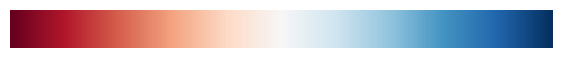

In [19]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(7, 0.5))
ax.imshow(gradient, aspect='auto', cmap='RdBu')
ax.set_axis_off()

plt.show()

- We will replace the darkest hue of red with a yellowish color which will be assigned to the counties belonging to the `"NA"` category.

In [20]:
px.colors.diverging.RdBu[0] = 'rgb(250, 230, 77)'
px.colors.diverging.RdBu

['rgb(250, 230, 77)',
 'rgb(178,24,43)',
 'rgb(214,96,77)',
 'rgb(244,165,130)',
 'rgb(253,219,199)',
 'rgb(247,247,247)',
 'rgb(209,229,240)',
 'rgb(146,197,222)',
 'rgb(67,147,195)',
 'rgb(33,102,172)',
 'rgb(5,48,97)']

- We will create a new column `ec_county_display` that will contain the economic connectedness (EC) data that would be displayed when hovering over the counties.

In [21]:
ec_county['ec_county_display'] = ec_county.ec_county.apply(
    lambda ec: "NA" if np.isnan(ec) else f'{round(ec, 2)}')

- Finally, we will create our choropleth map (using the plotly library).


- We provide our DataFrame sorted by the `bins` column in descending order because by default, the order of categorical values in legends depends on the order in which these values are first encountered in DataFrame.


- `locations` defines the name of the column whose values will be used for mapping with the `feature.id` property of the counties GeoJSON file specified in the `geojson` parameter.


- `color` defines the name of the column which will be used to color the map.

In [22]:
fig = px.choropleth(ec_county.sort_values(by="bins", ascending=False),
                    geojson=counties,
                    locations='county',
                    color='bins',
                    color_discrete_sequence=px.colors.diverging.RdBu[::-1],
                    scope="usa",
                    hover_data=['county_name', 'county', 'ec_county_display'],
                    labels={'bins': 'Economic Connectedness'})

fig.update_traces(
    hovertemplate = (
        '<b>%{customdata[0]}</b>'
        '<br><br>'
        'county=%{customdata[1]}'
        '<br>'
        'economic connectedness=%{customdata[2]}'
        '<extra></extra>'
    )
)

pyo.plot(fig, show_link=False, filename='choropleth_map.html')

'choropleth_map.html'

## Q2: Economic Connectedness and Outcomes

For the second question, we need to create the following scatter plot that displays the upward income mobility against economic connectedness (EC) for the 200 most populous United States counties.

- The original figure can be found [here](https://www.nature.com/articles/s41586-022-04996-4/figures/4).

![graph](media/household_income_economic_connectedness.png)

- First of all we will need to read the data for the economic connectedness (EC) by county.


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [23]:
ec_county = pd.read_csv('data/social_capital_county.csv',
                        usecols=['county', 'county_name', 'pop2018', 'ec_county'])
ec_county.head()

,county,county_name,pop2018,ec_county
0,1001,"Autauga, Alabama",55200.0,0.72077
1,1003,"Baldwin, Alabama",208107.0,0.74313
2,1005,"Barbour, Alabama",25782.0,0.41366
3,1007,"Bibb, Alabama",22527.0,0.63152
4,1009,"Blount, Alabama",57645.0,0.72562


- We will convert the `county` column to type string and we will use the `zfill()` function to add the leading zeros wherever missing.


- This will be useful later to merge the `ec_county` DataFrame with the DataFrame that will contain the upward mobility for each county.

In [24]:
ec_county['county'] = ec_county.county.apply(lambda c: str(c).zfill(5))
ec_county.head()

,county,county_name,pop2018,ec_county
0,01001,"Autauga, Alabama",55200.0,0.72077
1,01003,"Baldwin, Alabama",208107.0,0.74313
2,01005,"Barbour, Alabama",25782.0,0.41366
3,01007,"Bibb, Alabama",22527.0,0.63152
4,01009,"Blount, Alabama",57645.0,0.72562


- We will now read the data for the upward mobility by county.


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/the-opportunity-atlas/.

In [25]:
um_county = pd.read_csv('data/county_outcomes_simple.csv',
                        usecols=['state', 'county', 'kfr_pooled_pooled_p25'])
um_county.head()

,state,county,kfr_pooled_pooled_p25
0,1,1,0.361666
1,1,3,0.388847
2,1,5,0.349386
3,1,7,0.363391
4,1,9,0.391879


- The `kfr_pooled_pooled_p25` column corresponds to the mean household income rank for children whose parents were at the 25th percentile of the national income distribution (which is refered to as upward mobility in the context of the paper) based on the description of the variable in the documentation.


- For that reason, we will rename it accordingly to make it easier to understand.

In [26]:
um_county = um_county.rename(columns={"kfr_pooled_pooled_p25": "upward_mobility"})
um_county.head()

,state,county,upward_mobility
0,1,1,0.361666
1,1,3,0.388847
2,1,5,0.349386
3,1,7,0.363391
4,1,9,0.391879


- We need to merge the `ec_county` DataFrame with the `um_county` DataFrame to draw the plot.


- We will use the `state` and `county` columns to create a new `county_fips` column that we will later use to merge the above mentioned DataFrames.


- We will use `np.vectorize()` to make our function use the broadcasting rules of numpy.

In [27]:
vec_transform_to_fips = np.vectorize(lambda s, c: str(s).zfill(2) + str(c).zfill(3))
um_county['county_fips'] = vec_transform_to_fips(um_county.state, um_county.county)
um_county.head()

,state,county,upward_mobility,county_fips
0,1,1,0.361666,01001
1,1,3,0.388847,01003
2,1,5,0.349386,01005
3,1,7,0.363391,01007
4,1,9,0.391879,01009


- We will merge the information about economic connectedness (EC) and upward mobility by county.

In [28]:
df = pd.merge(left=ec_county,
              right=um_county[['county_fips', "upward_mobility"]],
              left_on='county',
              right_on='county_fips',
              how='inner')
df.head()

,county,county_name,pop2018,ec_county,county_fips,upward_mobility
0,01001,"Autauga, Alabama",55200.0,0.72077,01001,0.361666
1,01003,"Baldwin, Alabama",208107.0,0.74313,01003,0.388847
2,01005,"Barbour, Alabama",25782.0,0.41366,01005,0.349386
3,01007,"Bibb, Alabama",22527.0,0.63152,01007,0.363391
4,01009,"Blount, Alabama",57645.0,0.72562,01009,0.391879


- We will sort the `df` DataFrame by the population of the counties in descending order, and we will preserve the first 200 namely the 200 most populous counties.

In [29]:
df = df.sort_values(by='pop2018', ascending=False).iloc[:200].reset_index()
df.head()

,index,county,county_name,pop2018,ec_county,county_fips,upward_mobility
0,203,06037,"Los Angeles, California",10098052.0,0.73580,06037,0.431230
1,605,17031,"Cook, Illinois",5223719.0,0.75869,17031,0.384614
2,2598,48201,"Harris, Texas",4602523.0,0.67668,48201,0.418473
3,102,04013,"Maricopa, Arizona",4253913.0,0.74400,04013,0.398581
4,221,06073,"San Diego, California",3302833.0,0.90846,06073,0.425785


- We will use the `regplot()` function from seaborn to create the regression plot.


- We will use the Axes object returned by the `regplot()` function to customize the axis labels and add the annotations to the plot.

In [30]:
def draw_arrow(ax, title, county_name, xytext_x_adj, xytext_y):
    county = df[df.county_name == county_name]
    county_x = county.ec_county.iloc[0]
    county_y = county.upward_mobility.iloc[0]
    county_xy = (county_x, county_y)
    county_xytext = (county_x + xytext_x_adj, xytext_y)

    ax.annotate(title,
                xy=county_xy,
                xytext=county_xytext,
                ha="center",
                fontsize=10,
                arrowprops={
                    "fc": "black",
                    "ec": "white",
                    "width": 2,
                    "headwidth": 8,
                    "shrink": 0.05
                })

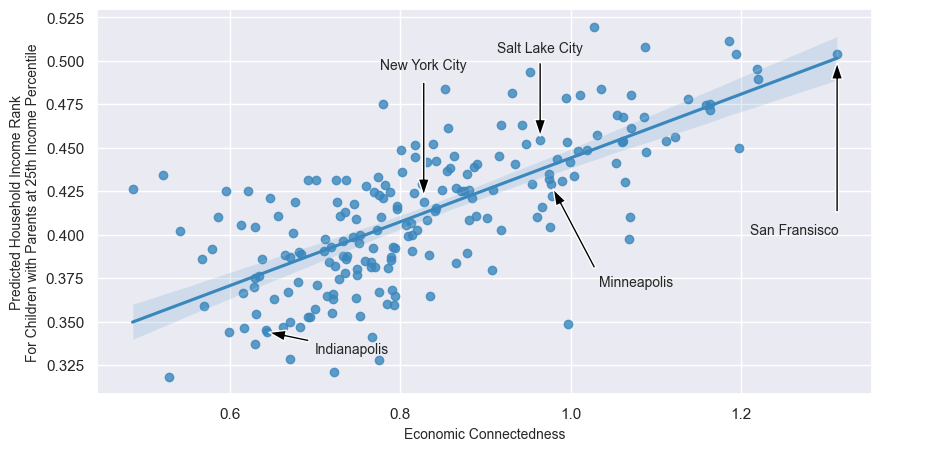

In [31]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10, 5)})
ax = sns.regplot(x='ec_county', y='upward_mobility', color='#3a87bd', data=df)
ax.set_xlabel('Economic Connectedness', size=10)
ax.set_ylabel('Predicted Household Income Rank\nFor Children with Parents at 25th Income Percentile', size=10)

draw_arrow(ax, '{county: <35}'.format(county='San Fransisco'), 'San Francisco, California', 0, 0.4)
draw_arrow(ax, 'Salt Lake City', 'Salt Lake, Utah', 0, 0.505)
draw_arrow(ax, 'Minneapolis', 'Hennepin, Minnesota', 0.1, 0.37)
draw_arrow(ax, 'New York City', 'New York, New York', 0, 0.495)
draw_arrow(ax, 'Indianapolis', 'Marion, Indiana', 0.1, 0.332)

plt.show()

## Q3: Upward Income Mobility, Economic Connectedness, and Median House Income

For the third question, we need to create the following scatter plot of economic connectedness (EC) against median household income by ZIP code (ZCTA). The color of the dots corresponds to the upward income mobility.

* The original figure can be found [here](https://www.nature.com/articles/s41586-022-04996-4/figures/6).

![graph](media/upward_mobility_connectedness_parental_income.png)

- First of all we will need to read the data for the economic connectedness (EC) by ZIP code (ZCTA).


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [32]:
ec_zcta = pd.read_csv('data/social_capital_zip.csv', usecols=['zip', 'ec_zip'])
ec_zcta.head()

,zip,ec_zip
0,1001,0.88157
1,1002,1.18348
2,1003,1.37536
3,1005,1.15543
4,1007,1.19240


- We will rename the `zip` column to `zcta` based on the description of the variable in the documentation.

In [33]:
ec_zcta = ec_zcta.rename(columns={"zip": "zcta"})
ec_zcta.head()

,zcta,ec_zip
0,1001,0.88157
1,1002,1.18348
2,1003,1.37536
3,1005,1.15543
4,1007,1.19240


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [34]:
ec_zcta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23028 entries, 0 to 23027
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   zcta    23028 non-null  int64  
 1   ec_zip  18980 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 359.9 KB


- We can see that there are some missing values for the `ec_zcta` column.

In [35]:
ec_zcta.ec_zip.isna().sum()

4048

In [36]:
ec_zcta.ec_zip.isna().mean()

0.17578599965259684

- We can see that the economic connectedness (EC) is missing for 4048 ZCTA codes, which corresponds to ~17% of the total.


- The documentation of the data states that in order to protect privacy, researchers only released economic connectedness (EC) for ZCTA codes that contained at least 100 low-SES and at least 100 high-SES individuals.


- For that reason, it is reasonable to drop the rows with missing economic connectedness (EC) and focus on the ZCTA codes that we have enough information about.

In [37]:
ec_zcta = ec_zcta.dropna(subset=['ec_zip']).reset_index(drop=True)

- We will convert the `zcta` column to type string and we will use the `zfill()` function to add the leading zeros wherever missing.


- This will be useful later to merge the `ec_zcta` DataFrame with the DataFrame that will contain the median household income for each ZCTA.

In [38]:
ec_zcta['zcta'] = ec_zcta.zcta.apply(lambda c: str(c).zfill(5))
ec_zcta.head()

,zcta,ec_zip
0,01001,0.88157
1,01002,1.18348
2,01003,1.37536
3,01005,1.15543
4,01007,1.19240


- We will now read the data for the median household income (based on the 2014–2018 ACS) by ZCTA code.


- The data as well as their documentation are available for download at https://data.census.gov/cedsci/table?q=median%20income&g=0100000US%248600000&tid=ACSST5Y2018.S1901.

In [39]:
mi_zcta = pd.read_csv('data/ACSST5Y2018.S1901-Data.csv', skiprows=[1], usecols=['NAME', 'S1901_C01_012E'])
mi_zcta.head()

,NAME,S1901_C01_012E
0,ZCTA5 00601,13092
1,ZCTA5 00602,16358
2,ZCTA5 00603,16603
3,ZCTA5 00606,12832
4,ZCTA5 00610,19309


- The `NAME` column corresponds to the ZCTA code and the `S1901_C01_012E` column corresponds to the median household income based on the description of the variables in the documentation.


- For that reason, we will rename the columns accordingly to make them easier to understand.

In [40]:
mi_zcta = mi_zcta.rename(columns={"NAME": "zcta", "S1901_C01_012E": "median_income"})
mi_zcta.head()

,zcta,median_income
0,ZCTA5 00601,13092
1,ZCTA5 00602,16358
2,ZCTA5 00603,16603
3,ZCTA5 00606,12832
4,ZCTA5 00610,19309


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [41]:
mi_zcta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   zcta           33120 non-null  object
 1   median_income  33085 non-null  object
dtypes: object(2)
memory usage: 517.6+ KB


- We can see that the `median_income` was not infered as type float by pandas.

In [42]:
mi_zcta.median_income.value_counts()

-         2194
46250       80
51250       75
53750       70
56250       66
          ... 
58246        1
80207        1
114033       1
42165        1
70356        1
Name: median_income, Length: 19796, dtype: int64

- The reason was that as we can see the `median_income` column contains some "-".


- The documentation states that a "-" entry in the estimate column indicates that either no sample observations or too few sample observations were available to compute an estimate, or a ratio of medians cannot be calculated because one or both of the median estimates falls in the lowest interval or upper interval of an open-ended distribution, or the margin of error associated with a median was larger than the median itself.


- We will convert the `median_income` column to type float, the "coerce" value passed as a parameter will convert the "-" to NaN.

In [43]:
mi_zcta['median_income'] = pd.to_numeric(mi_zcta.median_income, errors='coerce')
mi_zcta.head()

,zcta,median_income
0,ZCTA5 00601,13092.0
1,ZCTA5 00602,16358.0
2,ZCTA5 00603,16603.0
3,ZCTA5 00606,12832.0
4,ZCTA5 00610,19309.0


- Now we have new missing values to deal with.


- But let's first merge the `ec_zcta` DataFrame with the `mi_zcta` DataFrame to see how many of the missing values are actually refering to ZCTA codes that we are intrested in.


- We will remove the "ZCTA5" prefix from the values of the `zcta` column to be able to merge the `mi_zcta` DataFrame with the `ec_zcta` DataFrame created above.

In [44]:
mi_zcta['zcta'] = mi_zcta.zcta.apply(lambda z: z.split()[1])
mi_zcta.head()

,zcta,median_income
0,00601,13092.0
1,00602,16358.0
2,00603,16603.0
3,00606,12832.0
4,00610,19309.0


In [45]:
ec_mi_zcta = pd.merge(left=ec_zcta, right=mi_zcta, on='zcta', how='inner')
ec_mi_zcta.head()

,zcta,ec_zip,median_income
0,01001,0.88157,62144.0
1,01002,1.18348,55858.0
2,01003,1.37536,NaN
3,01005,1.15543,68278.0
4,01007,1.19240,93300.0


In [46]:
ec_mi_zcta.median_income.isna().sum()

69

In [47]:
ec_mi_zcta.median_income.isna().mean()

0.0036354056902002108

- We can see that the median household income is missing for only 69 ZCTA codes, so we can just drop those entries.

In [48]:
ec_mi_zcta = ec_mi_zcta.dropna(subset=['median_income']).reset_index(drop=True)

- Let's now plot the economic connectedness (EC) against median household income by ZCTA code (using the seaborn library).

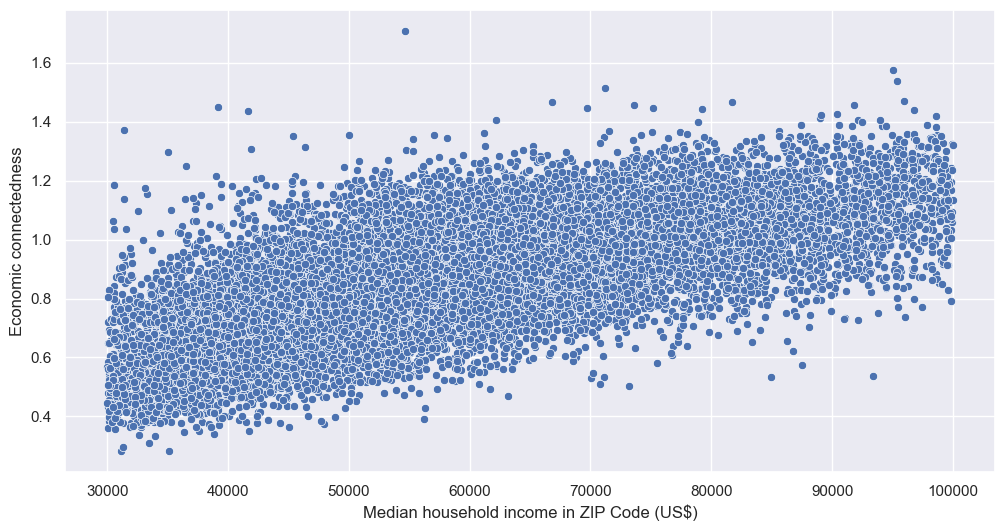

In [49]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.scatterplot(data=ec_mi_zcta[ec_mi_zcta.median_income.between(30_000, 100_000)],
                     x='median_income',
                     y='ec_zip')

ax.set_xlabel('Median household income in ZIP Code (US$)')
ax.set_ylabel('Economic connectedness')

plt.show()

- Now we will need the upward income mobility for each ZCTA code, in order to add the colors.


- Unfortunately we don't have the upward income mobility available in ZCTA code level.


- The [supplementary information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-04996-4/MediaObjects/41586_2022_4996_MOESM1_ESM.pdf) states that the researchers have aggregated the Census tract data on upward mobility to the ZIP code (ZCTA) level using the number of children with below-median parental income as weights.

- We will first read the data for the upward mobility by Census Tract.


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/the-opportunity-atlas/.

In [50]:
um_tract = pd.read_csv('data/tract_outcomes_simple.csv',
                       usecols=['state', 'county', 'tract', 'kfr_pooled_pooled_p25', 'pooled_pooled_count'])
um_tract.sample(5)

,state,county,tract,kfr_pooled_pooled_p25,pooled_pooled_count
57890,42,125,746301,0.515003,95.381111
27828,21,151,10102,0.366407,586.321230
57536,42,101,21300,0.458067,273.319490
33714,26,103,2900,0.472613,206.048870
15591,12,69,31310,0.449293,422.127900


- The `kfr_pooled_pooled_p25` column corresponds to the mean household income rank for children whose parents were at the 25th percentile of the national income distribution (which is refered to as upward mobility in the context of the paper) and the `pooled_pooled_count` column corresponds to the number of children under 18 living in the given tract with parents whose household income was below the national median based on the description of the variables in the documentation.


- For that reason, we will rename the columns accordingly to make them easier to understand.

In [51]:
um_tract = um_tract.rename(columns={"kfr_pooled_pooled_p25": "upward_mobility",
                                    "pooled_pooled_count": "num_below_p50"})
um_tract.head()

,state,county,tract,upward_mobility,num_below_p50
0,1,1,20100,0.367813,228.14854
1,1,1,20200,0.316781,391.91345
2,1,1,20300,0.373485,394.79211
3,1,1,20400,0.421511,388.38309
4,1,1,20500,0.433415,419.08334


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [52]:
um_tract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73278 entries, 0 to 73277
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            73278 non-null  int64  
 1   county           73278 non-null  int64  
 2   tract            73278 non-null  int64  
 3   upward_mobility  72014 non-null  float64
 4   num_below_p50    71950 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 2.8 MB


- We can see that there are some missing values for the `upward_mobility` and `num_below_p50` columns.

In [53]:
um_tract[['upward_mobility', 'num_below_p50']].isna().sum()

upward_mobility    1264
num_below_p50      1328
dtype: int64

In [54]:
um_tract[['upward_mobility', 'num_below_p50']].isna().mean()

upward_mobility    0.017249
num_below_p50      0.018123
dtype: float64

In [55]:
len(um_tract[(np.isnan(um_tract.upward_mobility) & (np.isnan(um_tract.num_below_p50)))])

1264

- We can see that the upward mobility is missing for 1264 tracts and the number of children whose parents have below median income is missing for 1328 tracts, which are less than 2% of the whole dataset.


- Also we can see that the missing values in those columns are missing together (in the same entries).


- Even if we wanted to, it would be really difficult to impute both of these values with reasonable estimates without any additional data, so we will drop them.

In [56]:
um_tract = um_tract.dropna().reset_index(drop=True)

- We will also drop the entries with the value of 0 at the `num_below_p50` column, because we will use it to compute the weighted average.

In [57]:
um_tract = um_tract[um_tract.num_below_p50 > 0].reset_index(drop=True)
um_tract.sample(5)

,state,county,tract,upward_mobility,num_below_p50
11708,8,7,940400,0.444103,180.18262
56768,42,95,10700,0.423783,427.79395
54309,41,53,20203,0.428130,441.14526
68107,51,700,32131,0.446609,484.29202
18746,13,89,23418,0.335729,1098.74260


- Finally, we will read the data that relate ZCTA codes to Census Tracts.


- The data as well as their documentation are available for download at https://www.census.gov/geographies/reference-files/2010/geo/relationship-files.html#par_textimage_674173622.

In [58]:
zt = pd.read_csv('data/zcta_tract_rel_10.txt', usecols=['ZCTA5', 'STATE', 'COUNTY', 'TRACT'])
zt.head()

,ZCTA5,STATE,COUNTY,TRACT
0,601,72,1,956300
1,601,72,1,956400
2,601,72,1,956500
3,601,72,1,956600
4,601,72,1,956700


- We will rename the columns of the `zt` DataFrame to match those of the `um_tract` DataFrame to simplify the merge that follows.

In [59]:
zt = zt.rename(columns={"ZCTA5": "zcta", "STATE": "state", "COUNTY": "county", "TRACT": "tract"})
zt.sample(5)

,zcta,state,county,tract
122747,80631,8,123,2209
10648,10528,36,119,7401
50647,33704,12,103,24002
54948,36442,1,61,50100
89902,59102,30,111,1801


- We will merge on `state`, `county` & `tract` because as stated in the documentation of the data each Census tract is uniquely identified by three identifiers – state, county, and tract.

In [60]:
um_zcta = pd.merge(left=zt, right=um_tract, on=['state', 'county', 'tract'], how='inner')
um_zcta.head(5)

,zcta,state,county,tract,upward_mobility,num_below_p50
0,1001,25,13,813205,0.478548,351.04105
1,1030,25,13,813205,0.478548,351.04105
2,1001,25,13,813206,0.451778,247.59004
3,1030,25,13,813206,0.451778,247.59004
4,1001,25,13,813207,0.435110,442.29269


- We will compute the upward mobility for each ZCTA as the weighted average of upward mobility at each tract (related to that ZCTA) weighted by the number of children with below median parental income as weights.

In [61]:
um_zcta = um_zcta.groupby('zcta') \
              .apply(lambda x: np.average(x.upward_mobility, weights=x.num_below_p50)) \
              .to_frame(name='upward_mobility') \
              .reset_index()
um_zcta.head(5)

,zcta,upward_mobility
0,1001,0.465349
1,1002,0.479825
2,1005,0.407809
3,1007,0.476621
4,1008,0.464829


- We will convert the `zcta` column to type string and we will use the `zfill()` function to add the leading zeros wherever missing.

In [62]:
um_zcta['zcta'] = um_zcta.zcta.apply(lambda c: str(c).zfill(5))

- We will merge all the information about economic connectedness (EC), median income and upward mobility.

In [63]:
df = pd.merge(left=ec_mi_zcta, right=um_zcta, on='zcta', how='inner')
df.head()

,zcta,ec_zip,median_income,upward_mobility
0,01001,0.88157,62144.0,0.465349
1,01002,1.18348,55858.0,0.479825
2,01005,1.15543,68278.0,0.407809
3,01007,1.19240,93300.0,0.476621
4,01010,0.73856,84471.0,0.492584


- The `qcut()` function is used to split the provided Series (or 1d ndarray) into quantiles (equal sized bins).


- We will use the `qcut()` to split the `upward_mobility` column into 5 quantiles.

In [64]:
bins = pd.qcut(df.upward_mobility, 5)
bins.value_counts(dropna=False).sort_index()

(0.211, 0.383]    3782
(0.383, 0.415]    3782
(0.415, 0.442]    3782
(0.442, 0.477]    3782
(0.477, 0.718]    3782
Name: upward_mobility, dtype: int64

- The categories created by `qcut()` are `Interval` objects.


- We can use these `Interval` objects to generate new categories that will match with those in the figure that we want to replicate.

In [65]:
new_categories = []
for i, interval in enumerate(bins.cat.categories, start=1):
    if i == 1:
        new_categories.append(f'< {int(interval.right * 100)}')
    elif i == len(bins.cat.categories):
        new_categories.append(f'> {int(interval.left * 100)}')
    else:
        new_categories.append(f'{interval.left * 100} - {interval.right * 100}')

- We will use the new categories to rename the auto-generated categories of the `bins` Series.

In [66]:
bins = bins.cat.rename_categories(new_categories=new_categories)
bins.dtype

CategoricalDtype(categories=['< 38', '38.3 - 41.5', '41.5 - 44.2',
                  '44.2 - 47.699999999999996', '> 47'],
, ordered=True)

- We will append the `bins` Series to the `df` DataFrame to use for the coloring.

In [67]:
df['upward_mobility'] = bins

- Finally, we will create the scatter plot (using the seaborn library).

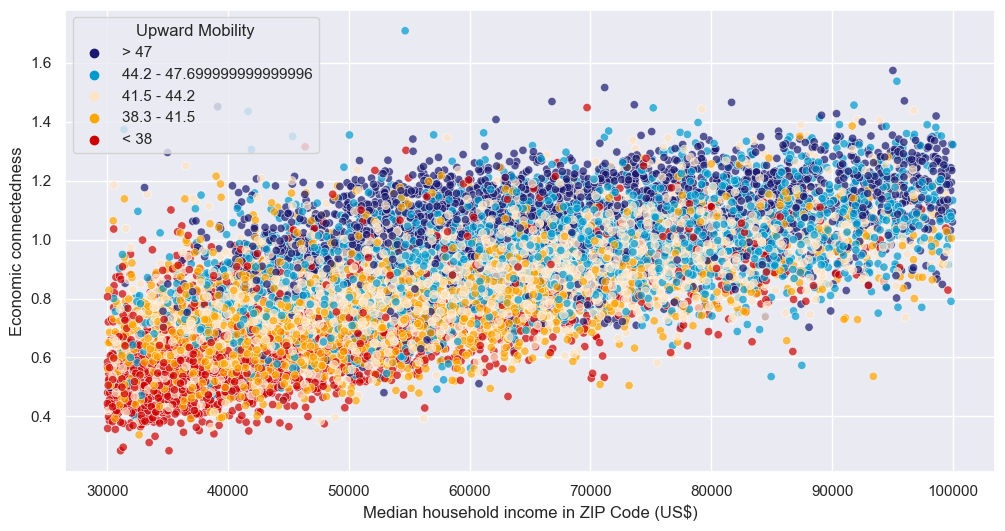

In [68]:
# Obtained using a color picker.
colors = ['#cd0000', '#ffa500', '#ffe4c4', '#009acd', '#191970']

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.scatterplot(data=df[df.median_income.between(30_000, 100_000)], 
                     x='median_income',
                     y='ec_zip',
                     hue='upward_mobility',
                     palette=sns.color_palette(colors, 5),
                     alpha=0.7)

ax.set_xlabel('Median household income in ZIP Code (US$)')
ax.set_ylabel('Economic connectedness')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Upward Mobility')

plt.show()

## Q4: Friending Bias and Exposure by High School

For the fourth question, we need to create the following scatter plot of friending bias (with an inverted vertical scale, so that moving up corresponds to less bias) against the share of students with high parental SES (that is, half of high-SES exposure) by high school.

- The original figure can be found [here](https://www.nature.com/articles/s41586-022-04997-3/figures/5).

![graph](media/friending_bias_exposure.png)

- First of all we will need to read the data for the friending bias and the exposure (from which we will obtain the share of students with high parental SES students) by high school.


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [69]:
ec_hs = pd.read_csv('data/social_capital_high_school.csv', usecols=['high_school', 'high_school_name', 'exposure_parent_ses_hs', 'bias_parent_ses_hs'])
ec_hs.head()

,high_school,high_school_name,exposure_parent_ses_hs,bias_parent_ses_hs
0,00000044,Holy Spirit Catholic School,NaN,NaN
1,00000226,John Carroll Catholic HS,1.44259,0.00285
2,00000237,Holy Family Cristo Rey Catholic HS,NaN,NaN
3,00000714,Montgomery Catholic Preparatory School,NaN,NaN
4,00000758,St Paul's Episcopal School,1.57514,-0.00050


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [70]:
ec_hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17525 entries, 0 to 17524
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   high_school             17525 non-null  object 
 1   high_school_name        17525 non-null  object 
 2   exposure_parent_ses_hs  11608 non-null  float64
 3   bias_parent_ses_hs      11608 non-null  float64
dtypes: float64(2), object(2)
memory usage: 547.8+ KB


- We can see that there are some missing values for the `exposure_parent_ses_hs` and `bias_parent_ses_hs` columns.

In [71]:
ec_hs[['exposure_parent_ses_hs', 'bias_parent_ses_hs']].isna().sum()

exposure_parent_ses_hs    5917
bias_parent_ses_hs        5917
dtype: int64

In [72]:
ec_hs[['exposure_parent_ses_hs', 'bias_parent_ses_hs']].isna().mean()

exposure_parent_ses_hs    0.337632
bias_parent_ses_hs        0.337632
dtype: float64

In [73]:
len(ec_hs[(np.isnan(ec_hs.exposure_parent_ses_hs) & (np.isnan(ec_hs.bias_parent_ses_hs)))])

5917

- We can see that the exposure and friending bias is missing for 5917 high schools, which corresponds to ~33% of the total (which is quite a lot).


- The documentation of the data states that in order to protect privacy, researchers only released estimates for high schools that contained at least 100 low-SES and at least 100 high-SES individuals.


- For that reason, it is reasonable to drop the rows with missing values and focus on the high schools that we have enough information about.

In [74]:
ec_hs = ec_hs.dropna().reset_index(drop=True)

- The `exposure_parent_ses_hs` column represents the mean exposure to high-parental-SES individuals by high school for low-parental-SES individuals which is measured as 2 times the average share of high-parental-SES individuals within three birth cohorts, averaged over low-parental-SES individuals. 


- Based on that we can devide by 2 the `exposure_parent_ses_hs` to obtain the share of high parental SES students by school.

In [75]:
ec_hs['share_high_parent_ses_students_hs'] = ec_hs.exposure_parent_ses_hs / 2
ec_hs.sample(5)

,high_school,high_school_name,exposure_parent_ses_hs,bias_parent_ses_hs,share_high_parent_ses_students_hs
5495,263384006930,Three Rivers HS,0.83449,-0.01628,0.417245
1033,060006908607,Valley Center HS,1.20932,0.03787,0.604660
1512,062610003906,Mountain Empire HS,0.89779,0.03928,0.448895
279,010000601585,Brindlee Mountain HS,0.61978,-0.02962,0.309890
1997,080612001037,Central HS,0.35514,-0.05002,0.177570


- Now that we have all the data required to create the plot let's take a look at the annotated high schools.

In [76]:
annotated_hs = ['00941729', '060474000432', '170993000942', '170993001185', '170993003989',
                '171449001804', '250327000436', '360009101928', '370297001285', '483702004138',
                '250843001336', '062271003230', '010237000962', '00846981', '00852124']

ec_hs[ec_hs.high_school.isin(annotated_hs)]

,high_school,high_school_name,exposure_parent_ses_hs,bias_parent_ses_hs,share_high_parent_ses_students_hs
234,00846981,Bishop Gorman HS,1.56995,0.00564,0.784975
235,00852124,Phillips Exeter Academy,1.56258,-0.01380,0.781290
275,00941729,Dalton School,1.41633,-0.00778,0.708165
447,010237000962,John L Leflore Magnet School,0.43748,-0.05177,0.218740
1108,060474000432,Berkeley HS,1.15111,0.11372,0.575555
1436,062271003230,North Hollywood Sr HS,0.67743,0.16764,0.338715
3186,170993000942,Lane Technical HS,0.95683,-0.01742,0.478415
3199,170993001185,Lincoln Park HS,0.94173,0.03471,0.470865
3204,170993003989,Payton College Preparatory HS,1.33149,0.00493,0.665745
3261,171449001804,Evanston Twp HS,1.30979,0.11782,0.654895


- We can see that for some of the schools the name does not exactly match with their labels in the figure we are trying to replicate, so we will rename them.

In [77]:
mapping = {
    "Evanston Twp HS": "Evanston Township HS",
    "Cambridge Rindge And Latin": "Cambridge Rindge & Latin School",
    "Payton College Preparatory HS": "Walter Payton College Prep",
    "John L Leflore Magnet School": "Leflore Magnet HS"
}

ec_hs['high_school_name'] = ec_hs.high_school_name.apply(lambda hs: mapping.get(hs, hs))

- Finally we will create the scatter plot (using the plotnine library).

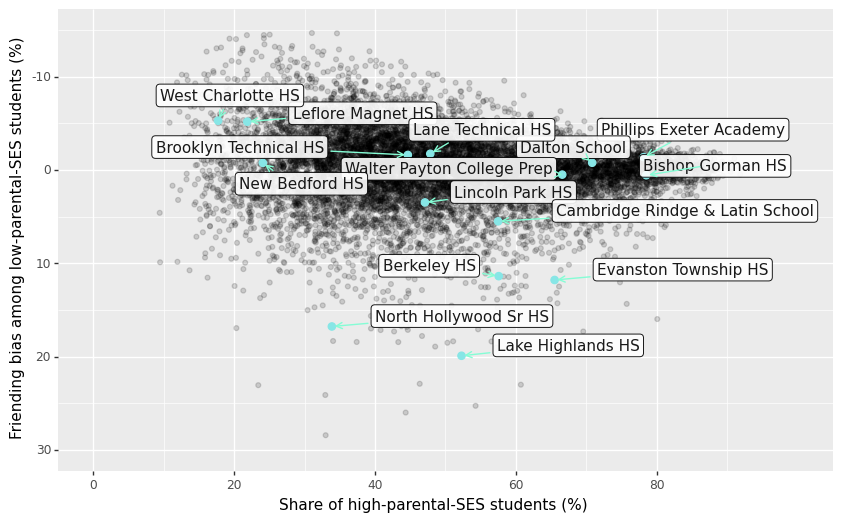

<ggplot: (156504923326)>

In [78]:
(ggplot() +
    geom_point(data=ec_hs,
               mapping=aes(x='share_high_parent_ses_students_hs', y='bias_parent_ses_hs'),
               alpha=0.15) +
 
    labs(x='Share of high-parental-SES students (%)',
         y='Friending bias among low-parental-SES students (%)') +
 
    scale_y_reverse(breaks=[-0.1, 0, 0.1, 0.2, 0.3],
                    minor_breaks=[-0.15, -0.05, 0.05, 0.15, 0.25],
                    labels=['-10', '0', '10', '20', '30'],
                    limits=[-0.15, 0.3]) +
 
    scale_x_continuous(breaks=[0, 0.2, 0.4, 0.6, 0.8],
                       minor_breaks=[0.1, 0.3, 0.5, 0.7, 0.9],
                       labels=['0', '20', '40', '60', '80'],
                       limits=[0, 1]) +
 
    geom_point(data=ec_hs[ec_hs.high_school.isin(annotated_hs)],
               mapping=aes(x='share_high_parent_ses_students_hs', y='bias_parent_ses_hs'),
               color='#87e6e6',
               size=2.5) +
 
    geom_label(data=ec_hs[ec_hs.high_school.isin(annotated_hs)],
               mapping=aes(x='share_high_parent_ses_students_hs',
                           y='bias_parent_ses_hs',
                           label='high_school_name'),
               alpha=0.9,
               adjust_text={
                 'expand_points': (1.6, 1.4),
                 'arrowprops': {
                    'arrowstyle': '->',
                    'color': '#85fdd5'
                }}) +
 
    theme(figure_size=(10, 6)))

## Q5: Friending Bias vs. Racial Diversity

For the fourth question, we need to create the following binned scatter plots of friending bias  against racial diversity within colleges (blue diamonds) and neighbourhoods (ZIP codes, orange circles).

- The original figure can be found [here](https://www.nature.com/articles/s41586-022-04997-3/figures/9).

![graph](media/friending_bias_racial_diversity.png)

- First of all we will need to read the data for the friending bias by neighborhood (ZIP code).


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [79]:
fb_zip = pd.read_csv('data/social_capital_zip.csv',
                     usecols=['zip', 'num_below_p50', 'nbhd_bias_zip'])
fb_zip.head()

,zip,num_below_p50,nbhd_bias_zip
0,1001,995.787468,-0.00336
1,1002,1312.117077,0.18724
2,1003,NaN,NaN
3,1005,381.519745,-0.00064
4,1007,915.396667,0.04162


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [80]:
fb_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23028 entries, 0 to 23027
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zip            23028 non-null  int64  
 1   num_below_p50  23002 non-null  float64
 2   nbhd_bias_zip  14285 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 539.8 KB


- We will now read the data for the racial shares (needed to compute the racial diversity) by ZIP code.


- The data can be found in the Replication Code and Data at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [81]:
rd_zip = pd.read_stata('data/zip_covariates.dta',
                       columns=['zip', 'share_white_2018', 'share_black_2018', 'share_hispanic_2018', 'share_asian_2018', 'share_hawaii_2018', 'share_natam_2018'])
rd_zip.head()

,zip,share_white_2018,share_black_2018,share_hispanic_2018,share_asian_2018,share_hawaii_2018,share_natam_2018
0,36006,0.838992,0.110624,0.010953,0.000000,0.000000,0.002191
1,36067,0.713614,0.214885,0.042155,0.004978,0.000174,0.004142
2,36749,0.707317,0.292683,0.000000,0.000000,0.000000,0.000000
3,36066,0.766194,0.161858,0.019165,0.029376,0.000000,0.003142
4,36051,0.807217,0.177113,0.015670,0.000000,0.000000,0.000000


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [82]:
rd_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32817 entries, 0 to 32816
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip                  32817 non-null  int32  
 1   share_white_2018     32637 non-null  float32
 2   share_black_2018     32637 non-null  float32
 3   share_hispanic_2018  32637 non-null  float32
 4   share_asian_2018     32637 non-null  float32
 5   share_hawaii_2018    32637 non-null  float32
 6   share_natam_2018     32637 non-null  float32
dtypes: float32(6), int32(1)
memory usage: 1.1 MB


- We will create a function to calculate the racial diversity by using the [Herfindahl-Hirschman Index (HHI)](https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index).


- We will use `np.vectorize()` to make our function use the broadcasting rules of numpy.

In [83]:
def calc_racial_diversity(share_white, share_black, share_hispanic, share_asian, share_hawaii_2018, share_natam):
    return 1 - (share_white**2 + share_black**2 + share_hispanic**2 + share_asian**2 + share_hawaii_2018**2 + share_natam**2)

vec_calc_racial_diversity = np.vectorize(calc_racial_diversity)

- We will create a new `racial_diversity` column that will contain the racial diverstity of each zip code.

In [84]:
rd_zip['racial_diversity'] = vec_calc_racial_diversity(rd_zip.share_white_2018,
                                                       rd_zip.share_black_2018,
                                                       rd_zip.share_hispanic_2018,
                                                       rd_zip.share_asian_2018,
                                                       rd_zip.share_hawaii_2018,
                                                       rd_zip.share_natam_2018)
rd_zip.head()

,zip,share_white_2018,share_black_2018,share_hispanic_2018,share_asian_2018,share_hawaii_2018,share_natam_2018,racial_diversity
0,36006,0.838992,0.110624,0.010953,0.000000,0.000000,0.002191,0.283729
1,36067,0.713614,0.214885,0.042155,0.004978,0.000174,0.004142,0.442760
2,36749,0.707317,0.292683,0.000000,0.000000,0.000000,0.000000,0.414039
3,36066,0.766194,0.161858,0.019165,0.029376,0.000000,0.003142,0.385509
4,36051,0.807217,0.177113,0.015670,0.000000,0.000000,0.000000,0.316785


- We will merge the `fb_zip` DataFrame with the necessary columns from the `rd_zip` DataFrame.

In [85]:
fb_rd_zip = pd.merge(left=fb_zip, right=rd_zip[['zip', 'racial_diversity']], on='zip')
fb_rd_zip.head()

,zip,num_below_p50,nbhd_bias_zip,racial_diversity
0,1001,995.787468,-0.00336,0.215376
1,1002,1312.117077,0.18724,0.470289
2,1003,NaN,NaN,0.471372
3,1005,381.519745,-0.00064,0.106795
4,1007,915.396667,0.04162,0.127465


- The `qcut()` function is used to split the provided Series into quantiles (equal sized bins).


- We will use the `qcut()` to split the `racial_diversity` column into 20 quantiles (called ventiles).

In [86]:
bins = pd.qcut(fb_rd_zip.racial_diversity, 20)
bins.value_counts(dropna=False).sort_index()

(-0.001, 0.0338]    1151
(0.0338, 0.0569]    1151
(0.0569, 0.0767]    1151
(0.0767, 0.0943]    1151
(0.0943, 0.114]     1151
(0.114, 0.136]      1151
(0.136, 0.163]      1150
(0.163, 0.193]      1151
(0.193, 0.232]      1151
(0.232, 0.272]      1151
(0.272, 0.314]      1151
(0.314, 0.359]      1151
(0.359, 0.405]      1151
(0.405, 0.448]      1150
(0.448, 0.487]      1151
(0.487, 0.522]      1151
(0.522, 0.558]      1151
(0.558, 0.6]        1151
(0.6, 0.653]        1151
(0.653, 0.894]      1151
NaN                    1
Name: racial_diversity, dtype: int64

- We will append the `bins` Series to the `fb_rd_zip` DataFrame to use it as the grouping column to calculate the weighted mean of HHI and the mean of the neighborhood bias.

In [87]:
fb_rd_zip['bins'] = bins
fb_rd_zip.head()

,zip,num_below_p50,nbhd_bias_zip,racial_diversity,bins
0,1001,995.787468,-0.00336,0.215376,"(0.193, 0.232]"
1,1002,1312.117077,0.18724,0.470289,"(0.448, 0.487]"
2,1003,NaN,NaN,0.471372,"(0.448, 0.487]"
3,1005,381.519745,-0.00064,0.106795,"(0.0943, 0.114]"
4,1007,915.396667,0.04162,0.127465,"(0.114, 0.136]"


- We will remove the missing values to calculate the racial divesrity (weighted mean of HHI) and the mean of the neighborhood bias.

In [88]:
fb_rd_zip = fb_rd_zip.dropna()

In [89]:
fb_rd_zip_bin = fb_rd_zip.groupby('bins') \
              .apply(lambda x: np.average(x.racial_diversity, weights=x.num_below_p50)) \
              .to_frame(name='racial_diversity')
fb_rd_zip_bin.head()

,racial_diversity
bins,
"(-0.001, 0.0338]",0.019998
"(0.0338, 0.0569]",0.045890
"(0.0569, 0.0767]",0.068396
"(0.0767, 0.0943]",0.085702
"(0.0943, 0.114]",0.104739


In [90]:
fb_rd_zip_bin['friending_bias'] = fb_rd_zip.groupby('bins') \
              .apply(lambda x: np.average(x.nbhd_bias_zip.mean())) \
              .to_frame(name='friending_bias')
fb_rd_zip_bin.head()

,racial_diversity,friending_bias
bins,,
"(-0.001, 0.0338]",0.019998,0.003144
"(0.0338, 0.0569]",0.045890,0.008984
"(0.0569, 0.0767]",0.068396,0.010033
"(0.0767, 0.0943]",0.085702,0.026057
"(0.0943, 0.114]",0.104739,0.033588


- We will reset the index of the `fb_rd_zip_bin` DataFrame and add a new `type` column that we will need later that we will concat it with the DataFrame that will contain the binned racial diversity and friending bias for colleges.

In [91]:
fb_rd_zip_bin = fb_rd_zip_bin.reset_index(drop=True)
fb_rd_zip_bin['type'] = 'Neighborhood'

- We will now read the data for the friending bias by college.


- The data as well as their documentation are available for download at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [92]:
fb_co = pd.read_csv('data/social_capital_college.csv',
                    usecols=['college', 'mean_students_per_cohort', 'bias_own_ses_college'])
fb_co.head()

,college,mean_students_per_cohort,bias_own_ses_college
0,100200,943.666667,-0.01200
1,100300,227.666667,-0.05807
2,100400,494.000000,-0.00504
3,100500,NaN,-0.03664
4,100700,NaN,0.05010


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [93]:
fb_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2586 entries, 0 to 2585
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   college                   2586 non-null   int64  
 1   mean_students_per_cohort  2097 non-null   float64
 2   bias_own_ses_college      2362 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 60.7 KB


- We will now read the data for the racial shares (needed to compute the racial diversity) by college.


- The data can be found in the Replication Code and Data at https://opportunityinsights.org/paper/social-capital-i-measurement-and-associations-with-economic-mobility/.

In [94]:
rd_co = pd.read_stata('data/college_characteristics.dta',
                      columns=[
                          'college',
                          'college_name',
                          'asian_or_pacific_share_fall_2000',
                          'black_share_fall_2000',
                          'hisp_share_fall_2000'
                      ])
rd_co.head()

,college,college_name,asian_or_pacific_share_fall_2000,black_share_fall_2000,hisp_share_fall_2000
0,161000,University Of Hawaii And Hawaii Community Coll...,0.716553,0.011714,0.018803
1,470100,San Bernardino Community College District,0.056209,0.151004,0.299666
2,120600,Coast Community College District,0.260676,0.018759,0.136386
3,998900,Santa Barbara Business College,0.036090,0.046617,0.401504
4,3695700,Rancho Santiago Community College District,0.142595,0.027094,0.386812


- We will use the `info()` function to get an overview of the DataFrame and ensure that the datatypes are correct.

In [95]:
rd_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2943 entries, 0 to 2942
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   college                           2943 non-null   int32  
 1   college_name                      2943 non-null   object 
 2   asian_or_pacific_share_fall_2000  2893 non-null   float32
 3   black_share_fall_2000             2893 non-null   float32
 4   hisp_share_fall_2000              2893 non-null   float32
dtypes: float32(3), int32(1), object(1)
memory usage: 92.0+ KB


- We can see that we only have racial shares for Asian, Black and Hispanic races.


- However as we can see below with the help of the `rd_zip` DataFrame the racial shares of Hawaii and Native American are less than 2% of the total.

In [96]:
rd_zip[['share_hawaii_2018', 'share_natam_2018']].mean()

share_hawaii_2018    0.000997
share_natam_2018     0.016555
dtype: float32

- The racial shares for each college are calculated as the number of the students that belong to each race divided by the total number of the students.


- Based on the above and on the fact that the racial shares for Hawaii and Native American races are negligible, we can calculate the racial share for the White race as percentage of the college citizens that are not Asian, Black or Hispanic.


- We will use `np.vectorize()` to make our function use the broadcasting rules of numpy.

In [97]:
def calc_white_share(asian_or_pacific_share, black_share, hisp_share):
    return 1 - asian_or_pacific_share - black_share - hisp_share

vec_calc_white_share = np.vectorize(calc_white_share)

- We will create a new `white_share_fall_2000` column that will contain the racial share of White undergraduate students of each college.

In [98]:
rd_co['white_share_fall_2000'] = vec_calc_white_share(rd_co.asian_or_pacific_share_fall_2000,
                                                      rd_co.black_share_fall_2000,
                                                      rd_co.hisp_share_fall_2000)
rd_co.head()

,college,college_name,asian_or_pacific_share_fall_2000,black_share_fall_2000,hisp_share_fall_2000,white_share_fall_2000
0,161000,University Of Hawaii And Hawaii Community Coll...,0.716553,0.011714,0.018803,0.252930
1,470100,San Bernardino Community College District,0.056209,0.151004,0.299666,0.493120
2,120600,Coast Community College District,0.260676,0.018759,0.136386,0.584179
3,998900,Santa Barbara Business College,0.036090,0.046617,0.401504,0.515789
4,3695700,Rancho Santiago Community College District,0.142595,0.027094,0.386812,0.443499


- We will create a function to calculate the racial diversity by using the [Herfindahl-Hirschman Index (HHI)](https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index).


- We will use `np.vectorize()` to make our function use the broadcasting rules of numpy.

In [99]:
def calc_racial_diversity(share_white, share_black, share_hispanic, share_asian):
    return 1 - (share_white**2 + share_black**2 + share_hispanic**2 + share_asian**2)

vec_calc_racial_diversity = np.vectorize(calc_racial_diversity)

- We will create a new `racial_diversity` column that will contain the racial diverstity of each college.

In [100]:
rd_co['racial_diversity'] = vec_calc_racial_diversity(rd_co.white_share_fall_2000,
                                                      rd_co.black_share_fall_2000,
                                                      rd_co.hisp_share_fall_2000,
                                                      rd_co.asian_or_pacific_share_fall_2000)
rd_co.head()

,college,college_name,asian_or_pacific_share_fall_2000,black_share_fall_2000,hisp_share_fall_2000,white_share_fall_2000,racial_diversity
0,161000,University Of Hawaii And Hawaii Community Coll...,0.716553,0.011714,0.018803,0.252930,0.422087
1,470100,San Bernardino Community College District,0.056209,0.151004,0.299666,0.493120,0.641071
2,120600,Coast Community College District,0.260676,0.018759,0.136386,0.584179,0.571830
3,998900,Santa Barbara Business College,0.036090,0.046617,0.401504,0.515789,0.569280
4,3695700,Rancho Santiago Community College District,0.142595,0.027094,0.386812,0.443499,0.632618


- We will merge the `fb_co` DataFrame with the necessary columns from the `rd_co` DataFrame.

In [101]:
fb_rd_co = pd.merge(left=fb_co, right=rd_co[['college', 'racial_diversity']], on='college')
fb_rd_co.head()

,college,mean_students_per_cohort,bias_own_ses_college,racial_diversity
0,100200,943.666667,-0.01200,0.172203
1,100300,227.666667,-0.05807,0.483553
2,100400,494.000000,-0.00504,0.260333
3,100500,NaN,-0.03664,0.152612
4,100700,NaN,0.05010,0.342416


- The `qcut()` function is used to split the provided Series into quantiles (equal sized bins).


- We will use the `qcut()` to split the `racial_diversity` column into 20 quantiles (called ventiles).

In [102]:
bins = pd.qcut(fb_rd_co.racial_diversity, 20)
bins.value_counts(dropna=False).sort_index()

(-0.001, 0.0453]    111
(0.0453, 0.0726]    110
(0.0726, 0.093]     111
(0.093, 0.113]      110
(0.113, 0.13]       110
(0.13, 0.148]       111
(0.148, 0.168]      110
(0.168, 0.191]      110
(0.191, 0.216]      111
(0.216, 0.243]      110
(0.243, 0.273]      110
(0.273, 0.301]      111
(0.301, 0.339]      110
(0.339, 0.379]      110
(0.379, 0.413]      111
(0.413, 0.457]      110
(0.457, 0.494]      110
(0.494, 0.538]      111
(0.538, 0.618]      114
(0.618, 0.739]      107
NaN                  22
Name: racial_diversity, dtype: int64

- We will append the `bins` Series to the `fb_rd_zip` DataFrame to use it as the grouping column to calculate the weighted mean of HHI and the mean of the college friending bias.

In [103]:
fb_rd_co['bins'] = bins
fb_rd_co.head()

,college,mean_students_per_cohort,bias_own_ses_college,racial_diversity,bins
0,100200,943.666667,-0.01200,0.172203,"(0.168, 0.191]"
1,100300,227.666667,-0.05807,0.483553,"(0.457, 0.494]"
2,100400,494.000000,-0.00504,0.260333,"(0.243, 0.273]"
3,100500,NaN,-0.03664,0.152612,"(0.148, 0.168]"
4,100700,NaN,0.05010,0.342416,"(0.339, 0.379]"


- We will remove the missing values to calculate the racial divesrity (weighted mean of HHI) and the mean of the college friending bias.

In [104]:
fb_rd_co = fb_rd_co.dropna()

In [105]:
fb_rd_co_bin = fb_rd_co.groupby('bins') \
              .apply(lambda x: np.average(x.racial_diversity, weights=x.mean_students_per_cohort)) \
              .to_frame(name='racial_diversity')
fb_rd_co_bin.head()

,racial_diversity
bins,
"(-0.001, 0.0453]",0.035257
"(0.0453, 0.0726]",0.060530
"(0.0726, 0.093]",0.084425
"(0.093, 0.113]",0.102346
"(0.113, 0.13]",0.125989


In [106]:
fb_rd_co_bin['friending_bias'] = fb_rd_co.groupby('bins') \
              .apply(lambda x: np.average(x.bias_own_ses_college.mean())) \
              .to_frame(name='friending_bias')
fb_rd_co_bin.head()

,racial_diversity,friending_bias
bins,,
"(-0.001, 0.0453]",0.035257,-0.019978
"(0.0453, 0.0726]",0.060530,-0.012796
"(0.0726, 0.093]",0.084425,-0.017737
"(0.093, 0.113]",0.102346,-0.009835
"(0.113, 0.13]",0.125989,0.006935


- We will reset the index of the `fb_rd_co_bin` DataFrame and add a new `type` column that we will need later to concat it with the `fb_rd_zip_bin` DataFrame.

In [107]:
fb_rd_co_bin = fb_rd_co_bin.reset_index(drop=True)
fb_rd_co_bin['type'] = 'College'

- We will concatenate the `fb_rd_zip_bin` DataFrame to the `fb_rd_co_bin` across the row (index) axis.

In [108]:
df = pd.concat([fb_rd_co_bin, fb_rd_zip_bin]).reset_index(drop=True)
df.head()

,racial_diversity,friending_bias,type
0,0.035257,-0.019978,College
1,0.060530,-0.012796,College
2,0.084425,-0.017737,College
3,0.102346,-0.009835,College
4,0.125989,0.006935,College


- We will convert the `friending_bias` column to (%).

In [109]:
df['friending_bias'] = df.friending_bias * 100

- Finally, we will create the binned scatter plots (using the seaborn library).

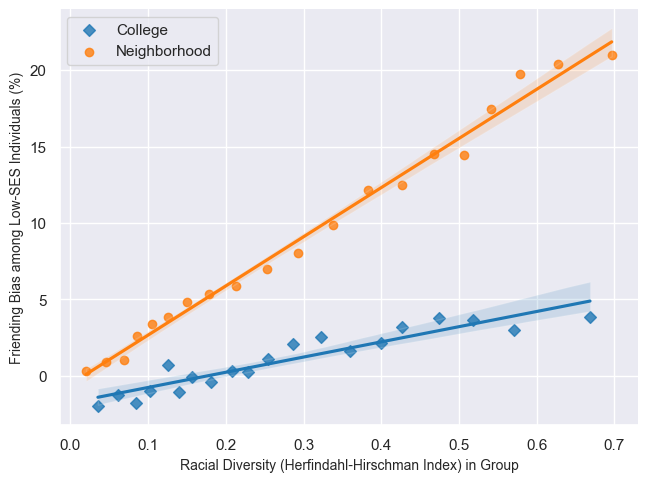

In [110]:
sns.set_style('darkgrid')
grid = sns.lmplot(x='racial_diversity',
                  y='friending_bias',
                  hue='type',
                  palette=sns.color_palette("tab10", 2),
                  markers=['D', 'o'],
                  legend=False,
                  data=df)

grid.ax.set_xlabel('Racial Diversity (Herfindahl-Hirschman Index) in Group', size=10)
grid.ax.set_ylabel('Friending Bias among Low-SES Individuals (%)', size=10)
grid.ax.legend(loc='upper left')
grid.figure.set_size_inches(7, 5)

plt.show()